<a href="https://colab.research.google.com/github/Amit-Ramrakhyani/PyTorch-Notebooks/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Datasets

Focusing of how to get your own data into PyTorch.

One of the ways to do so is to via: Custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.


## 0. Importing PyTorch and setting up device agnostic code

In [156]:
import torch
from torch import nn

# Checking torch version
torch.__version__

'2.0.1+cu118'

In [157]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [158]:
!nvidia-smi

Wed Jul 12 17:41:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |   1219MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get Data

The dataset is the subset of the Food101 dataset.

Food101 starts with 101 different classes of food and 1000 images per classes(750 training, 250 testing)

The dataset used in this notebook starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

In [159]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, staek, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak, sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [160]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its content."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [161]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [162]:
# Setup training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2.1 Visualizing an Image

Code for:
1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name `pathlib.Path.parent.stem`
4. Opening the image with Python's PIL
5. Show the image and print metadata


In [163]:
image_path

PosixPath('data/pizza_steak_sushi')

In [164]:
# /content/data/pizza_steak_sushi

Random image path: data/pizza_steak_sushi/test/sushi/988559.jpg
Image class: sushi
Image height: 288
Image width: 512


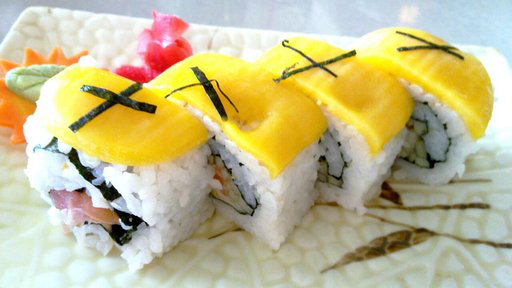

In [165]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from the path name (the image class in the name of the directory where the image is stored)
# .parent - gives the path of the parent direcory of the image
# .stem - gives the stem of that parent directory
image_class = random_image_path.parent.stem

# 4. Opening image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 287.5, -0.5)

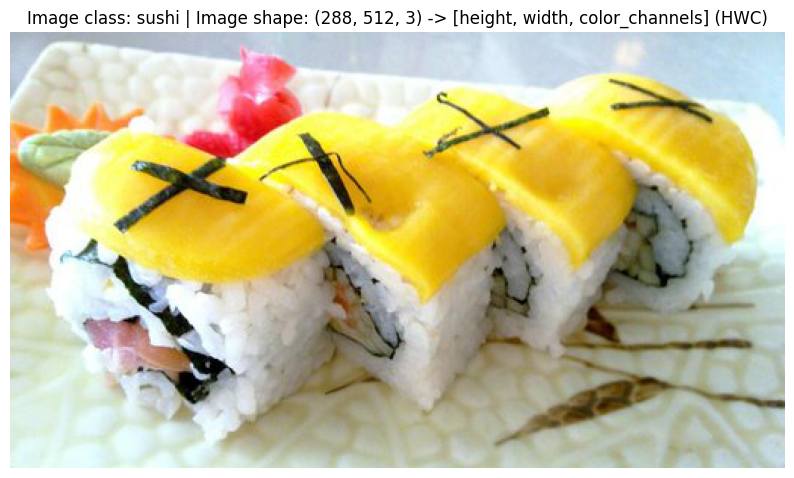

In [166]:
import numpy as np
import matplotlib.pyplot as plt

# Turning the image into an array
image_as_array = np.asarray(img)

# Plotting the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(image_as_array)
plt.title(f"Image class: {image_class} | Image shape: {image_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False)

In [167]:
image_as_array

array([[[166, 180, 193],
        [167, 181, 194],
        [167, 181, 194],
        ...,
        [180, 213, 230],
        [179, 212, 229],
        [179, 212, 229]],

       [[165, 179, 192],
        [166, 180, 193],
        [166, 180, 193],
        ...,
        [182, 215, 232],
        [180, 213, 230],
        [179, 212, 229]],

       [[166, 180, 193],
        [167, 181, 194],
        [167, 181, 194],
        ...,
        [184, 217, 234],
        [182, 215, 232],
        [180, 213, 230]],

       ...,

       [[228, 252, 239],
        [229, 253, 240],
        [228, 254, 243],
        ...,
        [196, 216, 227],
        [193, 213, 224],
        [188, 210, 221]],

       [[224, 248, 235],
        [226, 250, 237],
        [225, 251, 238],
        ...,
        [191, 211, 220],
        [189, 209, 218],
        [185, 205, 216]],

       [[217, 241, 227],
        [219, 243, 229],
        [220, 246, 233],
        ...,
        [189, 209, 218],
        [186, 206, 215],
        [182, 202, 211]]

## 3. Transforming data

Before using the image data with PyTorch:
1. Turn the target data into tensors (in this case, numerical representation of the images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`.

In [168]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms helps get the images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [169]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [170]:
data_transform(img)

tensor([[[0.6588, 0.6667, 0.6706,  ..., 0.7216, 0.7294, 0.7216],
         [0.6824, 0.6980, 0.6902,  ..., 0.7294, 0.7373, 0.7373],
         [0.7098, 0.7216, 0.7490,  ..., 0.7412, 0.7490, 0.7490],
         ...,
         [0.8824, 0.8824, 0.8784,  ..., 0.7255, 0.7647, 0.7686],
         [0.8863, 0.8784, 0.8784,  ..., 0.7176, 0.7490, 0.7725],
         [0.8784, 0.8824, 0.8902,  ..., 0.7216, 0.7255, 0.7569]],

        [[0.7137, 0.7216, 0.7098,  ..., 0.8471, 0.8588, 0.8549],
         [0.7373, 0.7490, 0.7333,  ..., 0.8588, 0.8667, 0.8706],
         [0.7608, 0.7725, 0.8000,  ..., 0.8667, 0.8745, 0.8784],
         ...,
         [0.9725, 0.9843, 0.9725,  ..., 0.7882, 0.8392, 0.8471],
         [0.9804, 0.9725, 0.9686,  ..., 0.7843, 0.8275, 0.8549],
         [0.9804, 0.9765, 0.9804,  ..., 0.7843, 0.7961, 0.8353]],

        [[0.7608, 0.7647, 0.7569,  ..., 0.9137, 0.9059, 0.9098],
         [0.7922, 0.8118, 0.7843,  ..., 0.9137, 0.9176, 0.9294],
         [0.8235, 0.8353, 0.8392,  ..., 0.9333, 0.9373, 0.

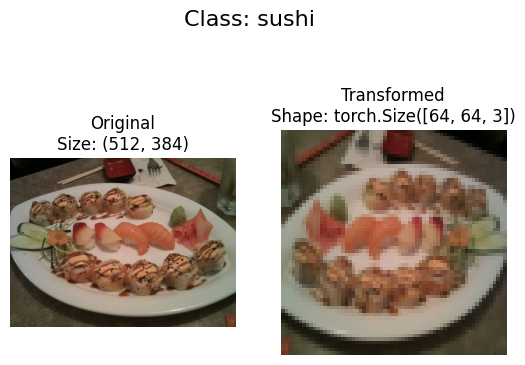

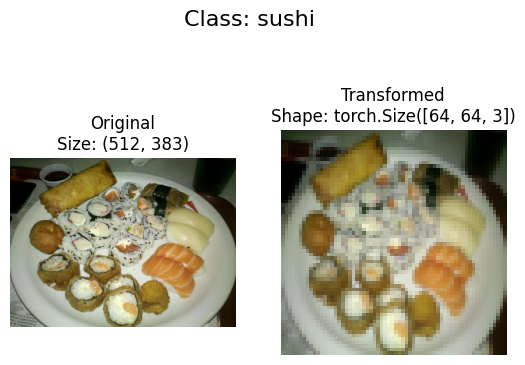

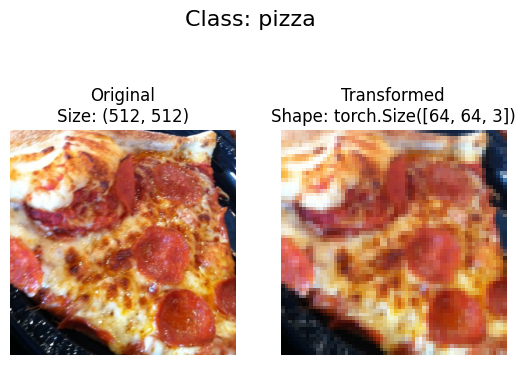

In [171]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images and loads/transforms them
  then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html

In [172]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [173]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [174]:
# Get class name as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [175]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [176]:
# Check the length of the dataset
len(train_data), len(test_data)

(225, 75)

In [177]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [178]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

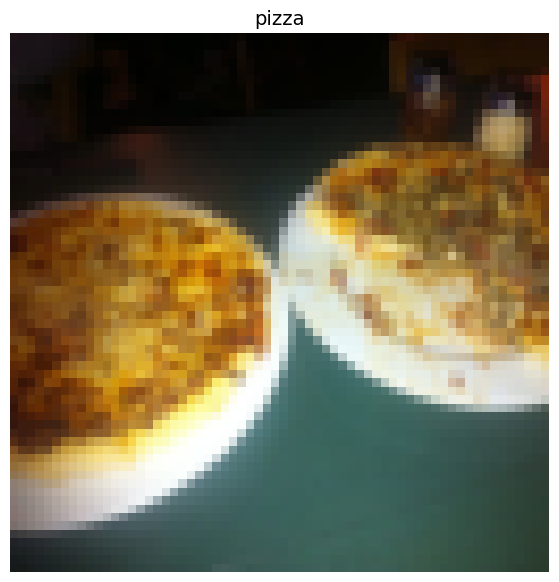

In [179]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

In [180]:
class_names[label]

'pizza'

### 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help turn the `Dataset`'s into iterables and we can customize the `batch_size` so the model can see `batch_size` images at a time.

In [181]:
import os
os.cpu_count()

2

In [182]:
# Turn train and test dataset into DatLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fc14aa2b520>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc14aa283a0>)

In [183]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [184]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from a file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though we could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [185]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [186]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise and error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [187]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [188]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [189]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Crete a custom `Dataset` to replicate `ImageFolder()`

To create own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to trasform the data.
3. Create several attributes:
  * paths - paths of the images
  * trasform - the trasform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwirte the `__len__()` method to return the length of the dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed an index

In [190]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize the custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all of the images path
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [191]:
img, label = train_data[0]

In [192]:
img, label

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [193]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
                                        transforms.Resize(size=(64, 64)),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.ToTensor()
])

test_transforms = transforms.Compose([
                                        transforms.Resize(size=(64, 64)),
                                        transforms.ToTensor()
])

In [194]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [195]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fc1453f7e80>,
 <__main__.ImageFolderCustom at 0x7fc1453f68f0>)

In [196]:
len(train_data), len(train_data_custom)

(225, 225)

In [197]:
len(test_data), len(test_data_custom)

(75, 75)

In [198]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [199]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [200]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of had, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matplotlib.
7. Make sure the dimensions of the images line up with matplotlib (HWC)

In [201]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape directly.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjust.shape}"
    plt.title(title)

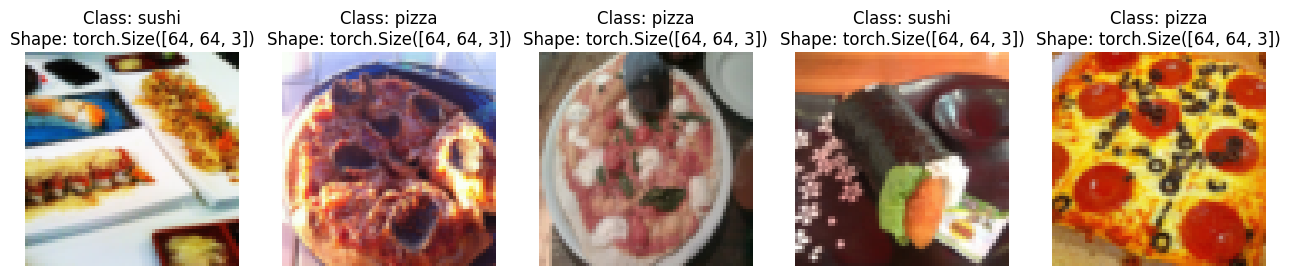

In [202]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

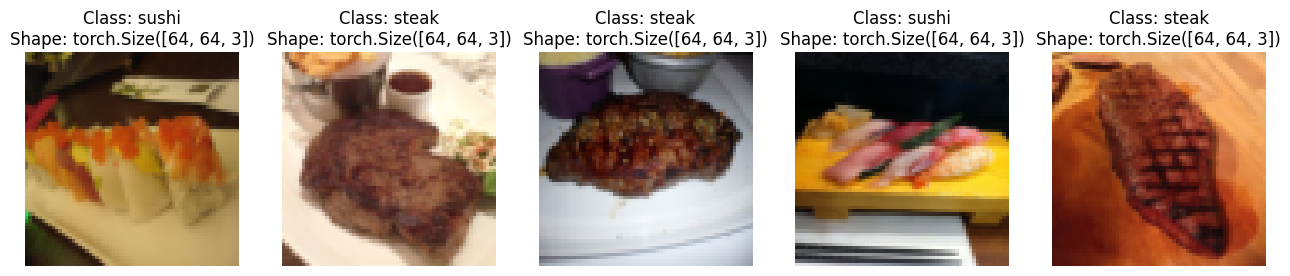

In [203]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [204]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fc1450b5f90>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc1450b44f0>)

In [205]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to the training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

Blog post - https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [206]:
# Let's look at trivialaugment - https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide
from torchvision import transforms

train_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.ToTensor()
])

In [207]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1627703.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg')]

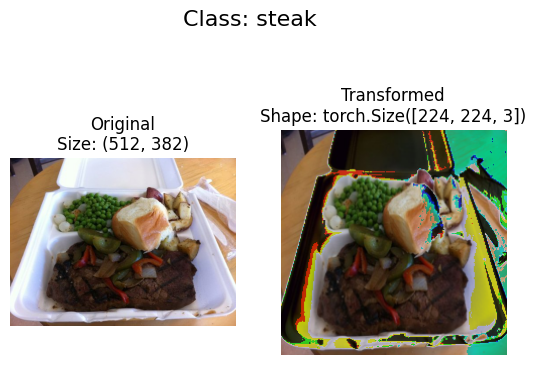

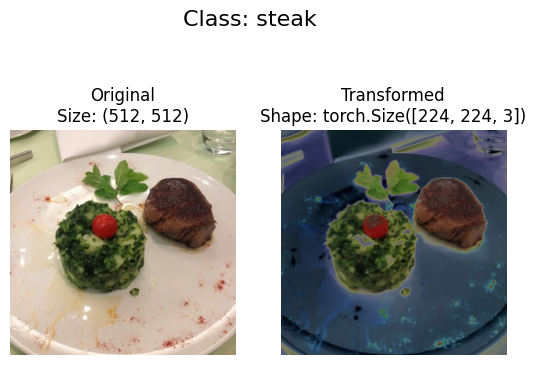

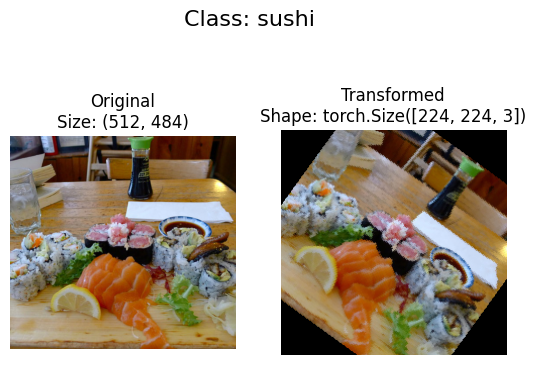

In [208]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

### 7.1 Creating transforms and loading data for Model 0

In [209]:
# Create simple transform
simple_transform = transforms.Compose([
                                        transforms.Resize(size=(64, 64)),
                                        transforms.ToTensor()
])

In [210]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [211]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, input_shape: int,
               hidden_units:int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride values is same as the kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride values is same as the kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
      x = self.conv_block_1(x)
      # print(x.shape)
      x = self.conv_block_2(x)
      # print(x.shape)
      x = self.classifier(x)
      # print(x.shape)
      return x
      # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: https://horace.io/brrr_intro.html

In [212]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in the image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [213]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [214]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6316e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2869e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7292e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1837e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4456e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7723e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5021e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4218e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8272e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

### 7.4 Using `torchinfo` to get an idea of the shapes going through the model

In [215]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [216]:
from torchinfo import summary
summary(model=model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [217]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust matrics to get the average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [218]:
# Create test_step()
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0
  # turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [234]:
from tqdm.auto import tqdm

# 1. Creating a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device
          ):
  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test_acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)


  # 6. Return the fileed results at the end of the epochs
  return results

### 7.7 Train and evaluate model 0

In [235]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of the target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test_acc: 0.3116
Epoch: 1 | Train loss: 1.0995 | Train acc: 0.3320 | Test loss: 1.0698 | Test_acc: 0.5417
Epoch: 2 | Train loss: 1.0862 | Train acc: 0.4922 | Test loss: 1.0799 | Test_acc: 0.5227
Epoch: 3 | Train loss: 1.0826 | Train acc: 0.4102 | Test loss: 1.0599 | Test_acc: 0.5729
Epoch: 4 | Train loss: 1.0631 | Train acc: 0.4141 | Test loss: 1.0611 | Test_acc: 0.5540
Total training time: 10.073 seconds


In [236]:
model_0_results

{'train_loss': [1.1063425093889236,
  1.0995025038719177,
  1.0862217992544174,
  1.0825757682323456,
  1.0630644857883453],
 'train_acc': [0.3046875, 0.33203125, 0.4921875, 0.41015625, 0.4140625],
 'test_loss': [1.098314603169759,
  1.0698072512944539,
  1.0799098014831543,
  1.0598717133204143,
  1.0611281394958496],
 'test_acc': [0.31155303030303033,
  0.5416666666666666,
  0.5227272727272728,
  0.5729166666666666,
  0.5539772727272728]}

### 7.8 Plot the loss curves of Model 0

A **loss curve** is a way of tracking the model's progress over time.

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [237]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [238]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary(training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

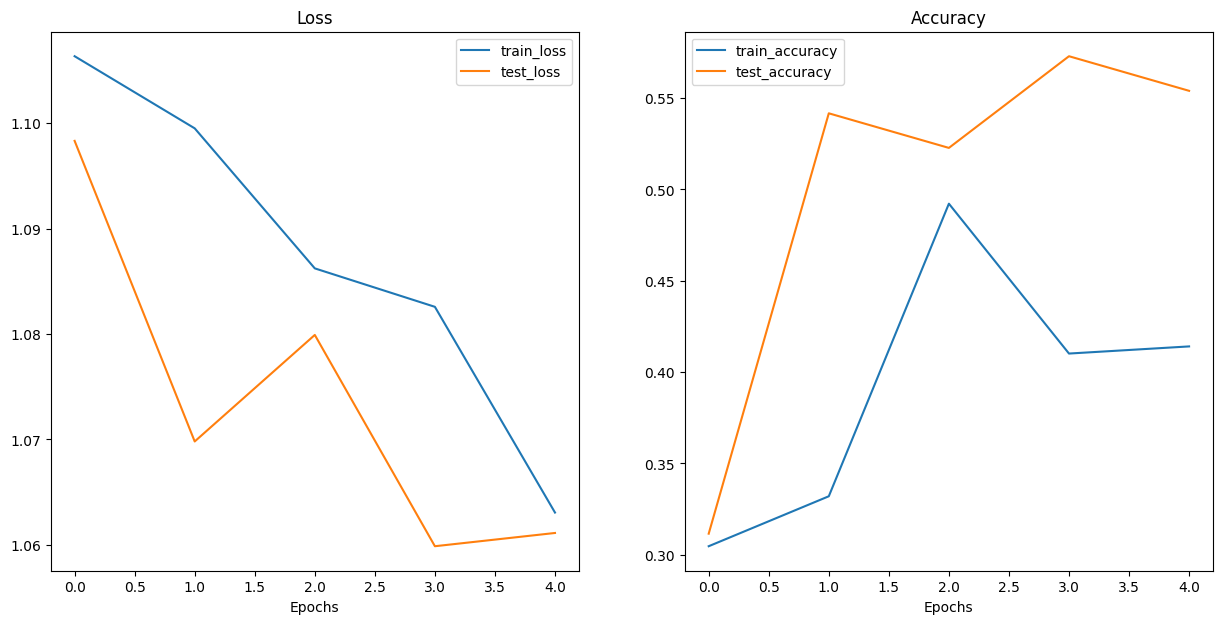

In [239]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with Data Augmentation

Trying another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Creating a transform with data augmentation

In [240]:
# Create training transform with TrivialAugment
from torchvision import transforms

train_transform_trivial = transforms.Compose([
                                              transforms.Resize(size=(64, 64)),
                                              transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                              transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
                                              transforms.Resize(size=(64, 64)),
                                              transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [241]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [242]:
# Turn the Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1

This time the same model architecture is used except this time the training data has been augmented.

In [243]:
# Create model_1 and sent it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Creating a loss function and an optimizer and calling upon the `train()` function to train and evaluate the model.

In [244]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# En the timer and printing out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.1019 | Test_acc: 0.2604
Epoch: 1 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss: 1.1261 | Test_acc: 0.2604
Epoch: 2 | Train loss: 1.0713 | Train acc: 0.4258 | Test loss: 1.1585 | Test_acc: 0.2604
Epoch: 3 | Train loss: 1.1249 | Train acc: 0.3047 | Test loss: 1.1586 | Test_acc: 0.2604
Epoch: 4 | Train loss: 1.0849 | Train acc: 0.4219 | Test loss: 1.1554 | Test_acc: 0.3229
Total training time for model_1: 9.487 seconds


In [245]:
model_1_results

{'train_loss': [1.1049069464206696,
  1.0806711465120316,
  1.0713441744446754,
  1.1249463856220245,
  1.0848778188228607],
 'train_acc': [0.25, 0.42578125, 0.42578125, 0.3046875, 0.421875],
 'test_loss': [1.1019322872161865,
  1.1260733405749004,
  1.1585209170977275,
  1.1585792501767476,
  1.1553788582483928],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.3229166666666667]}